<a href="https://colab.research.google.com/github/AlexSacMorane/LGCIV2041/blob/main/Truss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of the displacement method to solve 2D truss structures

This code was originally prepared for the course LGCIV1023 (Stabilité des Constructions), on Decembre 3 2019

Igor Bouckaert, João Pacheco de Almeida, Martin Steinmetz

Adapted for the course LGCIV2041 (Numerical Analysis of Civil Engineering Structures) by João Pacheco de Almeida on February 1 2023


# 0: INTRODUCTION

This code written for Google Colaboraty / Jupyter notebook aims to go step by step through a numerical solution of a truss structure with the displacement method.

To do this, simply run each cell of code one after the other and check what each one does.

**IMPORTANT**

Before starting, it is also necessary to run all the cells signaled with #DEFINITIONS within this section header, which define the different functions and libraries that will be used in the rest of the code.


## DEFINITIONS

Import the required libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

Display of the element undeformed configuration based on the connectivity (incidence) matrix

In [7]:
def PlotUndeformed(coord, connect) :

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                '#000000' )

    plt.plot(Coord[0], Coord[1], 'ro')

    for i in range(len(coord[1])) :
        plt.annotate(str(i), (coord[0][i], coord[1][i]))

    plt.show()

Display of the deformed configuration of the element

In [8]:
def PlotDeformed(coord, connect, displ, scale) :

    coord_def = coord + displ * scale

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                '#000000' )
        plt.plot([coord_def[0][connect[i][0]] , coord_def[0][connect[i][1]]] ,
                [coord_def[1][connect[i][0]] , coord_def[1][connect[i][1]]] ,
                'r-', linewidth=0.5)

    plt.plot(Coord[0], Coord[1], 'ro')

    for i in range(len(coord[1])) :
        plt.annotate(str(i), (coord[0][i], coord[1][i]))

    plt.show()

Display of the internal forces in the truss

In [9]:
def PlotAxialForces(coord, connect, N, scale_factor) :

    for i in range(len(connect)) :
        proportion = abs(N[i] / np.max(N))
        if (proportion > 0.0001 and N[i]<0) :
            color = 'r' # Compression
        elif (proportion > 0.0001 and N[i]>0):
            color = 'b' # Traction
        else : color = 'g-' # Effort nul

        # Epaisseur de trait proportionnelle à l'effort
        proportion = abs(N[i] / np.max(N))

        thickness = scale_factor
        if not (proportion < 0.0001 and proportion > -0.0001) :
            thickness = proportion * scale_factor

        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                color, linewidth = thickness )

# 1: INPUT
All parameters that need to be set by the user are listed in this section with # USER

## Bridge

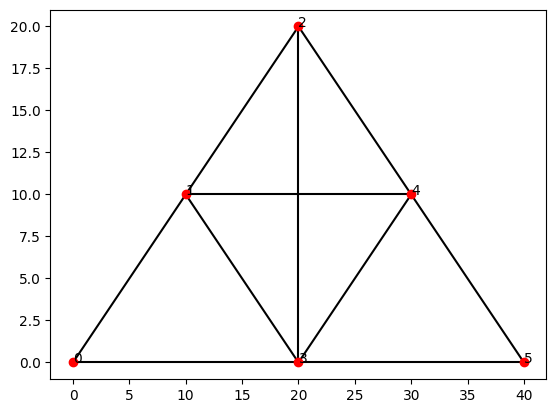

In [10]:
# Coordinates of the nodes: x in the first line and y in the second line, in [m].
Coord = np.array([[0, 10, 20, 20, 30, 40],
                  [0, 10, 20, 0, 10, 0]])

# Connectivity matrix defining the start and end nodes of each truss element.
# Attention, the indexing in Python starts at 0, so the first node is numbered 0 and the last is numbered (no. of nodes -1)
Connect = np.array([[0, 3],
                    [3, 5],
                    [1, 4],
                    [0, 1],
                    [1, 2],
                    [3, 4],
                    [4, 5],
                    [4, 2],
                    [1, 3],
                    [2, 3]])

# Display the truss
PlotUndeformed(Coord, Connect)

# Properties of the elements: it is assumed that all elements have the same properties
# E is the Young's modulus and A is the cross-sectional area of the truss elements

E_treillis = 70e9
A_treillis = 4000e-6

## Total number of degrees of freedom + numbering

In [11]:
No_Ddl = len(Coord[1])*2  #2 DoF per node for the trusses
No_DoF = np.arange(No_Ddl) # !! Indexing starts at 0 in Python
print('The structure has ' + str(No_Ddl) + ' degrees of freedom')

# Total number of elements
No_Elem = len(Connect)
print("The truss is composed of " + str(No_Elem) + " elements.")

# Building material matrix
E_treillis = np.ones(No_Elem)*E_treillis
A_treillis = np.ones(No_Elem)*A_treillis

# Fixed degrees of freedom
Fixed_DoF = np.array([0, 1, 10, 11])

# Free degrees of freedom
Free_DoF = np.delete(No_DoF, Fixed_DoF)

print('Free DoF',Free_DoF)

The structure has 12 degrees of freedom
The truss is composed of 10 elements.
Free DoF [2 3 4 5 6 7 8 9]


## Nodal loads

In [12]:
# Initialization
# P_f in [N]:
P = np.zeros(No_Ddl)
P_f = np.array([0, -1, 0, -1, 0, 0, 0, -1])*10000

# Building vector P
P[Free_DoF] = P_f

## Other

In [13]:
# Variable used to magnify the plot of deformed shape, if needed
Scale = 500

# 2: COMPUTATIONS

## Phase 1: Initialization of vectors and matrices

In [14]:
# Initialization of the vector of structural displacements
U = np.zeros(No_Ddl)
# The displacement vector corresponding to the fixed degrees of freedom is a zero vector
U_d = U[Fixed_DoF]

# Initialization of the local and global stiffness matrices of the elements, and of the structural stiffness matrix
K_str = np.zeros((No_Ddl, No_Ddl))
k_elem_loc = np.zeros((No_Elem,2,2))
k_elem_glob = np.zeros((No_Elem,4,4))

# Initialization of the matrices containing :
# 1. The lenght of the elements
L_Elem = np.zeros(No_Elem)
# 2. Rotation matrix for each element
r_C = np.zeros((No_Elem,2,4))
# 3. Assembly matrix
Assembly = np.zeros((No_Elem, 4))

## Phase 2: Elements' length, rotation matrices, and assembly matrix
Loop over the elements to calculate their respective lengths, rotation matrices, and assembly matrix

In [15]:
for i in range(No_Elem) :

    # 1. Element's length
    L_x = Coord[0][Connect[i][1]] - Coord[0][Connect[i][0]]  # Length in x
    L_y = Coord[1][Connect[i][1]] - Coord[1][Connect[i][0]]  # Length in y
    L_Elem[i] = np.sqrt(L_x**2 + L_y**2)

    # 2. Rotation matrices [[cos sin 0 0],[0 0 cos sin]]
    sin = L_y / L_Elem[i] # Sine of the rotation angle of truss element i
    cos = L_x / L_Elem[i] # Cosine of the rotation angle of truss element i
    r_C[i] = np.array([[cos, sin, 0, 0],
                      [0, 0, cos, sin]])

    # Auxiliary matrices for the assembly: positioning of local matrices in the global matrix
    Assembly[i] = np.array([Connect[i][0]*2,
                              Connect[i][0]*2+1,
                              Connect[i][1]*2,
                              Connect[i][1]*2+1])
    Assembly = Assembly.astype(int)

# Computation of the stiffness of truss elements, EA/L bars
k_barre = A_treillis * E_treillis / L_Elem

## Phase 3: Computation of local stiffness matrices
Loop through the elements to calculate their respective local stiffness matrices in the local (k_loc) and global (k_glob) reference system, followed by assembly into the structural stiffness matrix

NOTE: the matrix product is written '@' in Python

In [16]:
for elem in range(No_Elem) :

    # Stiffness matrices in the local reference system
    k_elem_loc[elem] = np.array([[k_barre[elem], -k_barre[elem]],
                             [-k_barre[elem], k_barre[elem]]])

    # Stiffness matrices in the global reference system
    k_elem_glob[elem] = np.transpose(r_C[elem]) @ k_elem_loc[elem] @ r_C[elem]

    # Assembly of the global structural stiffness matrix
    for j in range(len(k_elem_glob[elem])) :
        for k in range(len(k_elem_glob[elem])) :
            K_str[Assembly[elem][j]][Assembly[elem][k]] += k_elem_glob[elem][j][k]

## Phase 4: Partitioning of the stiffness matrix

In [17]:
# Sub-matrix for the free DoFs:
K_ff = K_str[Free_DoF[:,None], Free_DoF[None,:]]

# Sub-matrix for the fixed DoFs:
K_dd = K_str[Fixed_DoF[:,None], Fixed_DoF[None,:]]

# Sub-matrices K_fd et K_df:

K_fd = K_str[Free_DoF[:,None], Fixed_DoF[None,:]]
K_df = np.transpose(K_fd)

## Phase 5: Displacement's equation

Solving the displacement equation to find the value of the free degrees of freedom

In [18]:
U_f = inv(K_ff) @ (P_f - K_fd @ U_d)

# Completing the global displacement vector:
U[Free_DoF] = U_f

## Phase 6: Reactions' equation

Solving the reactions' equation to find the unknown reactions in the structure

In [19]:
P_d = K_df @ U_f + K_dd @ U_d

# Completing the vector of nodal forces:
P[Fixed_DoF] = P_d

# Computing the structural resisting forces:
P_r = K_str @ U

## Phase 7: Computation of internal forces

In [20]:
# Initialization of vectors u_loc et p_loc
u_loc = np.zeros((No_Elem, 2))
p_loc = np.zeros((No_Elem, 2))

for i in range(No_Elem) :
    u_loc[i] = r_C[i] @ U[Assembly[i]]
    p_loc[i] = k_elem_loc[i] @ u_loc[i]

# Axial forces
p_loc = np.transpose(p_loc)
N = p_loc[1]

# 3: DISPLAY

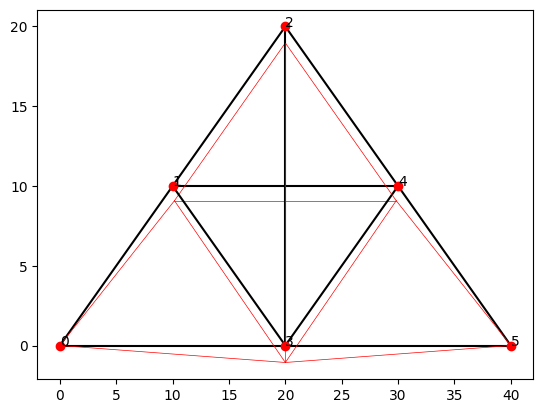

Axial forces in the elements [kN] : 
[ -0.     0.    -9.14 -21.21  -7.68  -0.61 -21.21  -7.68  -0.61   0.86]


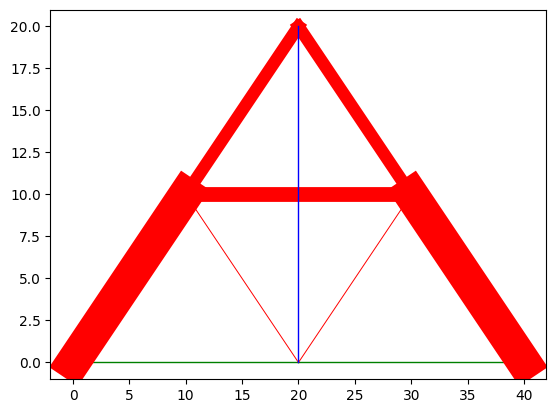

In [21]:
# Display the deformed shape of the structure:
Disp = np.zeros((2,len(Coord[0])))
Disp[0] = U[np.arange(len(Coord[0]))*2]
Disp[1] = U[np.arange(len(Coord[0]))*2+1]

PlotDeformed(Coord, Connect, Disp, Scale)

# Displaying the axial forces in the elements:
ScaleN = 1
PlotAxialForces(Coord, Connect, N, ScaleN)
print("Axial forces in the elements [kN] : ")
print(np.around(N/1000,2))